# Plot indel reads pileup

In [1]:
import os
import pandas as pd
import numpy as np
from Bio import Seq, SeqIO
import itertools
import matplotlib.pyplot as plt
from collections import Counter
from Bio import Align
from matplotlib import cm
from matplotlib import colors
import matplotlib.patches as mpatches
import multiprocessing as mp
import matplotlib.image as image
import pysam
import gzip
import seaborn as sns
from scipy import stats
import math
import logomaker
from functools import reduce
from scipy.spatial.distance import hamming
from glob import glob
from matplotlib import ticker
import matplotlib as mpl
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from statsmodels.graphics.factorplots import interaction_plot
from bioinfokit.analys import stat
import scikit_posthocs as sp
import bz2
%matplotlib inline
%config InlineBackend.figure_format = 'png'
plt.rcParams['svg.fonttype'] = 'none'
mpl.rcParams['figure.dpi']= 300

## Read data

In [2]:
datadir = 'pileups_indels'

In [3]:
ampl_name = 'GFP'

In [4]:
control = 'GFP-EMPTY_S1'

In [41]:
indel_pileup_files = glob(os.path.join(datadir, 'GFP*_pileup_indel_reads.tsv'))
indel_pileup_files.sort()
indel_pileup_files = indel_pileup_files[::-1]
indel_pileup_data = {f.split('/')[-1].replace('_pileup_indel_reads.tsv', ''):pd.read_csv(f, sep='\t', index_col=0) for f in indel_pileup_files}

In [45]:
indel_pileup_data['GFP-1-B_S3'][indel_pileup_data['GFP-1-B_S3']['cov']>1e4]['cov'].median()

177253.0

## Read amplicons

In [6]:
basedir = './'

In [7]:
spike = str([rec.seq for rec in SeqIO.parse(os.path.join(basedir, 'amplicons/spike.fasta'), 'fasta')][0])
EGFP = str([rec.seq for rec in SeqIO.parse(os.path.join(basedir, 'amplicons/EGFP.fasta'), 'fasta')][0])

EGFP_F_S = 'CGAGCTGAAGGGCATCGAC'
EGFP_R_S = 'CTCGTCCATGCCGAGAGTGA'
EGFP_amplicon_S = EGFP[EGFP.find(EGFP_F_S):EGFP.find(str(Seq.Seq(EGFP_R_S).reverse_complement()))+len(EGFP_R_S)]

spike_F_S = 'TGCCATCGGCAAGATTCAAG'
spike_R_S = 'TGCCACAAAAGTCGACCCG'
spike_amplicon_S = spike[spike.find(spike_F_S):spike.find(str(Seq.Seq(spike_R_S).reverse_complement()))+len(spike_R_S)]

ampls = {'GFP':EGFP, 'spike':spike}

In [8]:
ampl_coords = {'GFP':(EGFP.find(EGFP_amplicon_S), EGFP.find(EGFP_amplicon_S)+len(EGFP_amplicon_S)),
    'spike':(spike.find(spike_amplicon_S), spike.find(spike_amplicon_S)+len(spike_amplicon_S))}

In [9]:
ampl_coords

{'GFP': (371, 708), 'spike': (2786, 3133)}

## Guides

In [10]:
guide_seq = {'GFP':{'B':'caacgagaagcgcgatcaca', '1':'gagcTaagaccccaacgaga'},
             'spike':{'1':'CGACCCACCGGAAGCAGAAG', 'B':'CAAATTGATCGCCTGATAAC'}}

In [11]:
guide_pos = {ampl:{g:ampls[ampl].find(guide_seq[ampl][g].upper()) for g in guide_seq[ampl]} for ampl in guide_seq}

In [13]:
guides_by_sample = {
    'GFP-EMPTY_S1':[],
    'GFP-1_S2':['1'],
    'GFP-1-B_S3':['1', 'B'],
    'SPIKE-RT-EMPTY_S9':[],
    'SPIKE-RT-1-B_S10':['1', 'B'],
    'SPIKE-EVO-EMPTY_S11':[],
    'SPIKE-EVO-1-B_S12':['1', 'B']
}

In [14]:
nick_sites = {s:{g:guide_pos[ampl_name][g]+3 if g!='B' else guide_pos[ampl_name][g]+17 for g in guides_by_sample[s]}
              for s in indel_pileup_data}

## Plot pileup

In [15]:
def make_af_to_plot(pileup):
    af_to_plot = {'pos':[], 'A':[], 'C':[], 'G':[], 'T':[]}
    for i in pileup.index:
        for b in ['A', 'C', 'G', 'T']:
            if b != pileup.loc[i, 'ref'] and pileup.loc[i, 'cov']>1e2:
                af_to_plot[b].append(pileup.loc[i, b]/pileup.loc[i, 'cov'])
            else:
                af_to_plot[b].append(0.0)
        af_to_plot['pos'].append(pileup.loc[i, 'pos'])
    return pd.DataFrame(af_to_plot).fillna(0)

In [16]:
upstream_window = 5
downstream_window = 20

In [17]:
af_to_plot = {f:make_af_to_plot(indel_pileup_data[f]) for f in indel_pileup_data}

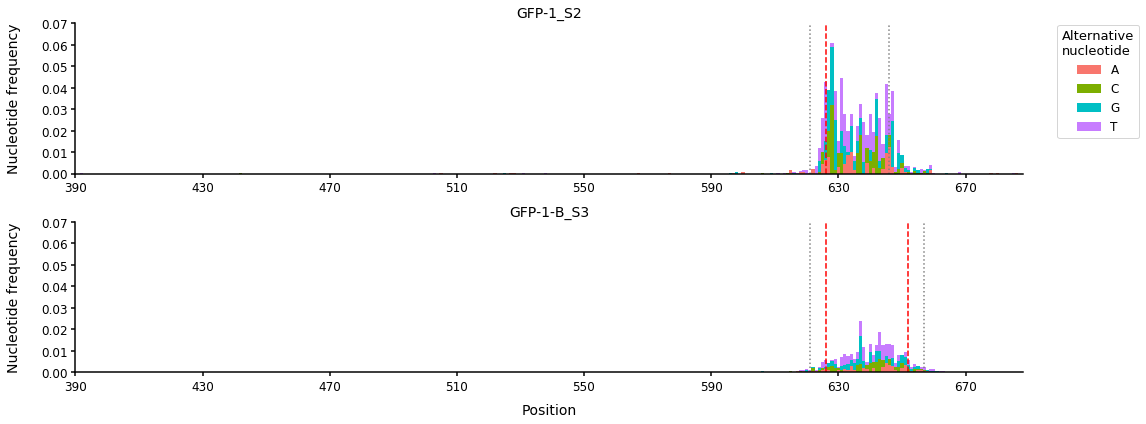

In [18]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(16, 6))

for n,f in enumerate(['GFP-1_S2', 'GFP-1-B_S3']):
    af_to_plot[f][['A', 'C', 'G', 'T']].plot(kind='bar', stacked=True, ax=ax[n],
        legend=False, width=1, color = ['#f8766d', '#7cae00', '#00bfc4','#c77cff'])
    ymax = {'GFP-1_S2':0.07, 'GFP-1-B_S3':0.07}
    ax[n].set_ylim(0, ymax[f])
    ax[n].set_xlim(ampl_coords[ampl_name][0]+19, ampl_coords[ampl_name][1]-20)
    ax[n].set_xticks([i for i in range(ampl_coords[ampl_name][0]+19, ampl_coords[ampl_name][1]-20, 40)])
    ax[n].set_xticklabels([i for i in range(ampl_coords[ampl_name][0]+19, ampl_coords[ampl_name][1]-20, 40)], size=12, rotation=0)
    for y in ax[n].get_yticklabels():
        y.set_size(12)
    ax[n].set_title(f, size=14)
    ax[n].spines['right'].set_visible(False)
    ax[n].spines['left'].set_linewidth(1.5)
    ax[n].spines['top'].set_visible(False)
    ax[n].spines['bottom'].set_linewidth(1.5)
    ax[n].tick_params(width=1.5, length=4)
    ax[n].set_ylabel('Nucleotide frequency', size=14, labelpad=20, color='k')
    guide_names = guides_by_sample[f]
    for guide_name in guide_names:
        nick = nick_sites[f][guide_name]
        ax[n].vlines(nick, 0, ymax[f], color='red', linestyle='--')
        if 'B' not in guide_names:
            ax[n].vlines(nick-upstream_window, 0, ymax[f], color='gray', linestyle='dotted')
            ax[n].vlines(nick+downstream_window, 0, ymax[f], color='gray', linestyle='dotted')
        else:
            if guide_name=='B':
                ax[n].vlines(nick+upstream_window, 0, ymax[f], color='gray', linestyle='dotted')
            else:
                ax[n].vlines(nick-upstream_window, 0, ymax[f], color='gray', linestyle='dotted')

lgd = ax[0].legend(loc='upper left', bbox_to_anchor=(1.03, 1.03),
                title ='Alternative\nnucleotide', prop={'size':12}, ncol=1)
plt.setp(lgd.get_title(),fontsize='13')
ax[-1].set_xlabel('Position', size=14, labelpad=10)
    
plt.tight_layout()
plt.show()

## Make base substitution image

In [18]:
window_start = nick_sites['GFP-1-B_S3']['1'] - upstream_window
window_end = nick_sites['GFP-1-B_S3']['B'] + upstream_window
alt_base_count = {}
bases = ['A', 'C', 'G', 'T']
for f in indel_pileup_data:
    alt_base_count[f] = {'og_'+b:{b2:0 for b2 in bases if b2!=b} for b in bases}
    for i in range(window_start, window_end):
            ref = indel_pileup_data[f].loc[i, 'ref']
            for b in bases:
                if b!=ref:
                    alt_base_count[f]['og_'+ref][b] += indel_pileup_data[f].loc[i, b]

In [19]:
alt_base_count = {f:pd.DataFrame(alt_base_count[f]).transpose().fillna(0)[
    ['A', 'C', 'G', 'T']] for f in alt_base_count}

In [20]:
alt_base_count['GFP-1-B_S3'].sum().sum()

27216.0

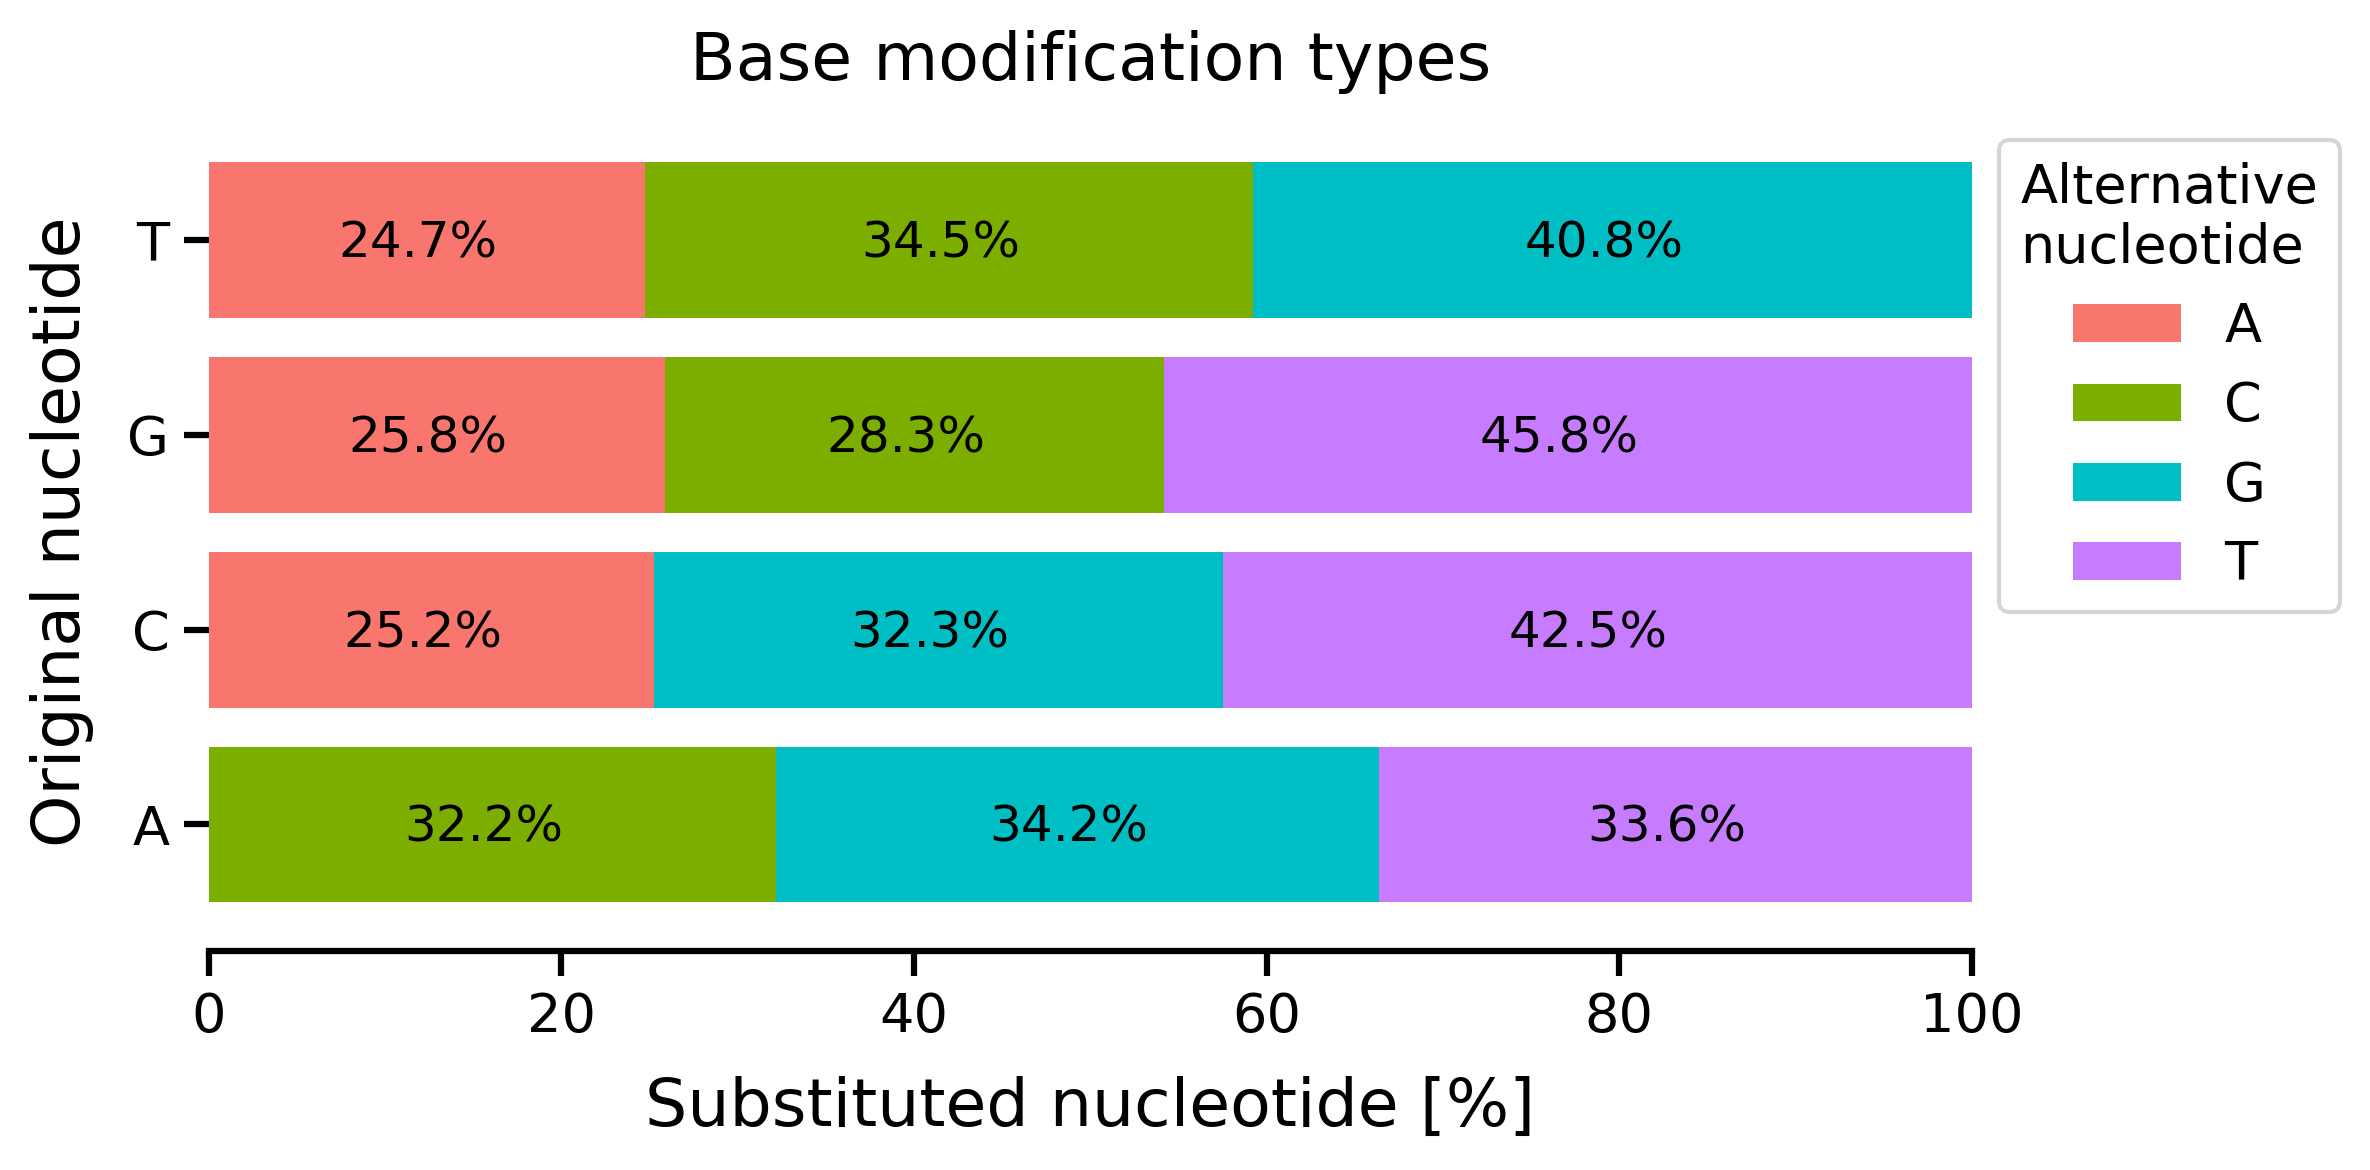

In [23]:
name = 'GFP-1-B_S3'
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 4))
perc = alt_base_count[name].divide(alt_base_count[name].sum(axis=1), axis=0).multiply(100)
perc_cumsum = perc.apply(np.cumsum, axis=1)

ax = perc.plot(kind='barh', stacked=True, width=0.8, ax=ax,
    legend=False, #color = ['#ca0020','#f4a582','#92c5de','#0571b0'])
    color = ['#f8766d', '#7cae00', '#00bfc4','#c77cff']) 
ax.set_title('Base modification types', size=16, pad=8)
ax.set_xlabel('Substituted nucleotide [%]', size=16, labelpad=8)

lgd = ax.legend(loc='upper left', bbox_to_anchor=(1, 1),
                title ='Alternative\nnucleotide', prop={'size':13}, ncol=1)
plt.setp(lgd.get_title(),fontsize='13')
ax.set_yticklabels([y.split('_')[1] for y in perc.index])

for y in ax.get_yticklabels():
    y.set_size(13)
for x in ax.get_xticklabels():
    x.set_size(13)
    x.set_rotation(0)
    
for jy,j in enumerate(perc.index):
    for ix,i in enumerate(perc.columns):
        if perc.loc[j, i]>0:
            x_base = perc_cumsum.loc[j].iloc[ix-1] if ix>0 else 0
            x = (perc_cumsum.loc[j, i]+x_base)/2
            ax.text(x-5, jy-0.09, '{:.1f}%'.format(perc.loc[j, i]), color='k',
                   size=12)

ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_linewidth(1.5)

#ax.tick_params(axis='y', which='major', pad=80)
#ax.tick_params(left=False)
ax.tick_params(width=1.5, length=6)
    
ax.set_xlim(0,100)    
ax.set_ylabel('Original nucleotide', size=16, labelpad=8)
plt.tight_layout()
plt.show()
#plt.savefig('Figures/'+name+'_base_modification_types.svg')

## Pileup by indel type

In [21]:
pileup_files_by_indel = glob(os.path.join(datadir, 'split_pileup/GFP*_pileup_*_reads.tsv'))
pileup_files_by_indel.sort()
pileup_files_by_indel = pileup_files_by_indel[::-1]

In [26]:
pileup_data_by_indel = {}
for f in pileup_files_by_indel:
    s_name = f.split('/')[-1].split('_pileup')[0]
    if s_name not in pileup_data_by_indel:
        pileup_data_by_indel[s_name] = {}
    indel_type = f.split('/')[-1].split('_pileup_')[1].replace('_reads.tsv', '')
    pileup_data_by_indel[s_name][indel_type] = pd.read_csv(f, sep='\t', index_col=0)

In [27]:
af_to_plot_by_indel = {f:{indel:make_af_to_plot(pileup_data_by_indel[f][indel]) for indel in pileup_data_by_indel[f]} for f in pileup_data_by_indel}

In [57]:
pileup_data_by_indel['GFP-1-B_S3']['Insertion'][pileup_data_by_indel['GFP-1-B_S3']['Insertion']['cov']>1e4]['cov'].median()

28115.5

In [52]:
pileup_data_by_indel['GFP-1-B_S3']['Deletion'][pileup_data_by_indel['GFP-1-B_S3']['Deletion']['cov']>1e4]['cov'].median()

112198.0

In [55]:
pileup_data_by_indel['GFP-1-B_S3']['Indel'][pileup_data_by_indel['GFP-1-B_S3']['Indel']['cov']>1e3]['cov'].median()

4963.0

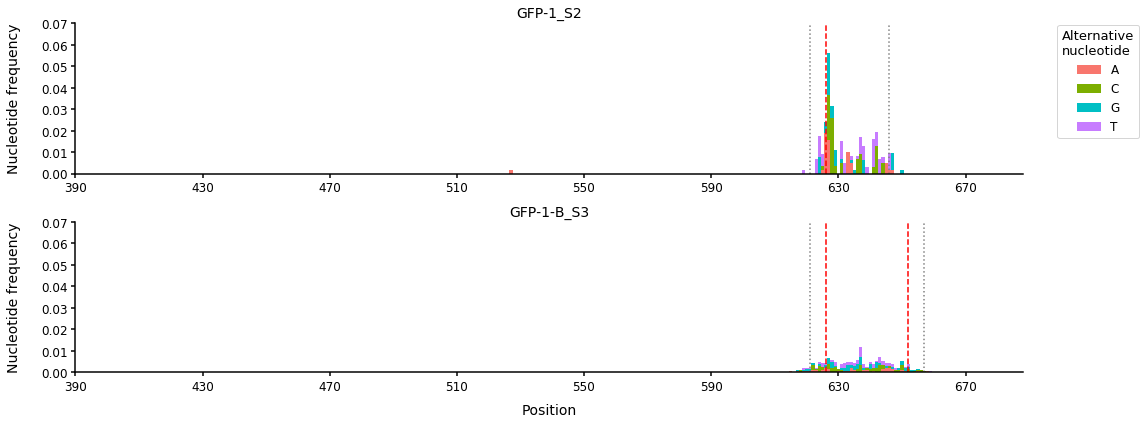

In [28]:
indel = 'Insertion'

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(16, 6))

for n,f in enumerate(['GFP-1_S2', 'GFP-1-B_S3']):
    af_to_plot_by_indel[f][indel][['A', 'C', 'G', 'T']].plot(kind='bar', stacked=True, ax=ax[n],
        legend=False, width=1, color = ['#f8766d', '#7cae00', '#00bfc4','#c77cff'])
    ymax = {'GFP-1_S2':0.07, 'GFP-1-B_S3':0.07}
    ax[n].set_ylim(0, ymax[f])
    ax[n].set_xlim(ampl_coords[ampl_name][0]+19, ampl_coords[ampl_name][1]-20)
    ax[n].set_xticks([i for i in range(ampl_coords[ampl_name][0]+19, ampl_coords[ampl_name][1]-20, 40)])
    ax[n].set_xticklabels([i for i in range(ampl_coords[ampl_name][0]+19, ampl_coords[ampl_name][1]-20, 40)], size=12, rotation=0)
    for y in ax[n].get_yticklabels():
        y.set_size(12)
    ax[n].set_title(f, size=14)
    ax[n].spines['right'].set_visible(False)
    ax[n].spines['left'].set_linewidth(1.5)
    ax[n].spines['top'].set_visible(False)
    ax[n].spines['bottom'].set_linewidth(1.5)
    ax[n].tick_params(width=1.5, length=4)
    ax[n].set_ylabel('Nucleotide frequency', size=14, labelpad=20, color='k')
    guide_names = guides_by_sample[f]
    for guide_name in guide_names:
        nick = nick_sites[f][guide_name]
        ax[n].vlines(nick, 0, ymax[f], color='red', linestyle='--')
        if 'B' not in guide_names:
            ax[n].vlines(nick-upstream_window, 0, ymax[f], color='gray', linestyle='dotted')
            ax[n].vlines(nick+downstream_window, 0, ymax[f], color='gray', linestyle='dotted')
        else:
            if guide_name=='B':
                ax[n].vlines(nick+upstream_window, 0, ymax[f], color='gray', linestyle='dotted')
            else:
                ax[n].vlines(nick-upstream_window, 0, ymax[f], color='gray', linestyle='dotted')

lgd = ax[0].legend(loc='upper left', bbox_to_anchor=(1.03, 1.03),
                title ='Alternative\nnucleotide', prop={'size':12}, ncol=1)
plt.setp(lgd.get_title(),fontsize='13')
ax[-1].set_xlabel('Position', size=14, labelpad=10)
    
plt.tight_layout()
plt.show()

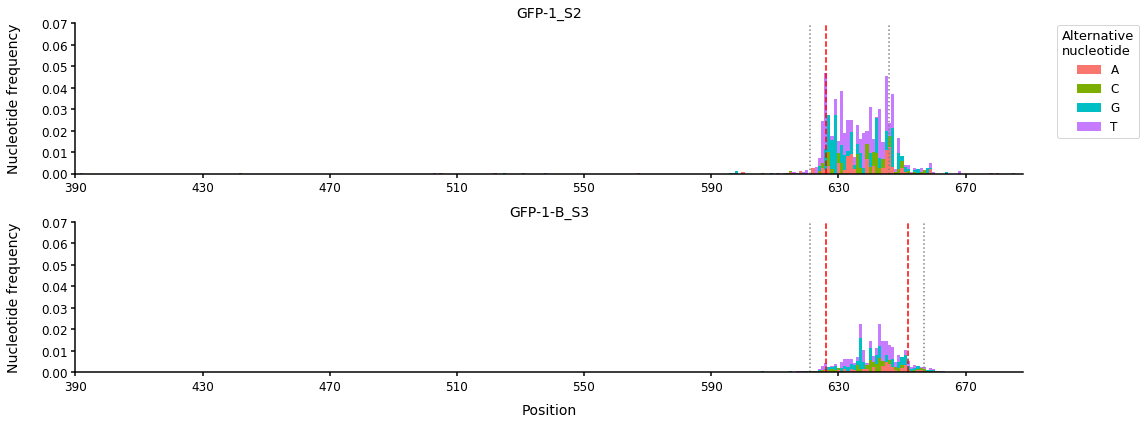

In [29]:
indel = 'Deletion'

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(16, 6))

for n,f in enumerate(['GFP-1_S2', 'GFP-1-B_S3']):
    af_to_plot_by_indel[f][indel][['A', 'C', 'G', 'T']].plot(kind='bar', stacked=True, ax=ax[n],
        legend=False, width=1, color = ['#f8766d', '#7cae00', '#00bfc4','#c77cff'])
    ymax = {'GFP-1_S2':0.07, 'GFP-1-B_S3':0.07}
    ax[n].set_ylim(0, ymax[f])
    ax[n].set_xlim(ampl_coords[ampl_name][0]+19, ampl_coords[ampl_name][1]-20)
    ax[n].set_xticks([i for i in range(ampl_coords[ampl_name][0]+19, ampl_coords[ampl_name][1]-20, 40)])
    ax[n].set_xticklabels([i for i in range(ampl_coords[ampl_name][0]+19, ampl_coords[ampl_name][1]-20, 40)], size=12, rotation=0)
    for y in ax[n].get_yticklabels():
        y.set_size(12)
    ax[n].set_title(f, size=14)
    ax[n].spines['right'].set_visible(False)
    ax[n].spines['left'].set_linewidth(1.5)
    ax[n].spines['top'].set_visible(False)
    ax[n].spines['bottom'].set_linewidth(1.5)
    ax[n].tick_params(width=1.5, length=4)
    ax[n].set_ylabel('Nucleotide frequency', size=14, labelpad=20, color='k')
    guide_names = guides_by_sample[f]
    for guide_name in guide_names:
        nick = nick_sites[f][guide_name]
        ax[n].vlines(nick, 0, ymax[f], color='red', linestyle='--')
        if 'B' not in guide_names:
            ax[n].vlines(nick-upstream_window, 0, ymax[f], color='gray', linestyle='dotted')
            ax[n].vlines(nick+downstream_window, 0, ymax[f], color='gray', linestyle='dotted')
        else:
            if guide_name=='B':
                ax[n].vlines(nick+upstream_window, 0, ymax[f], color='gray', linestyle='dotted')
            else:
                ax[n].vlines(nick-upstream_window, 0, ymax[f], color='gray', linestyle='dotted')

lgd = ax[0].legend(loc='upper left', bbox_to_anchor=(1.03, 1.03),
                title ='Alternative\nnucleotide', prop={'size':12}, ncol=1)
plt.setp(lgd.get_title(),fontsize='13')
ax[-1].set_xlabel('Position', size=14, labelpad=10)
    
plt.tight_layout()
plt.show()

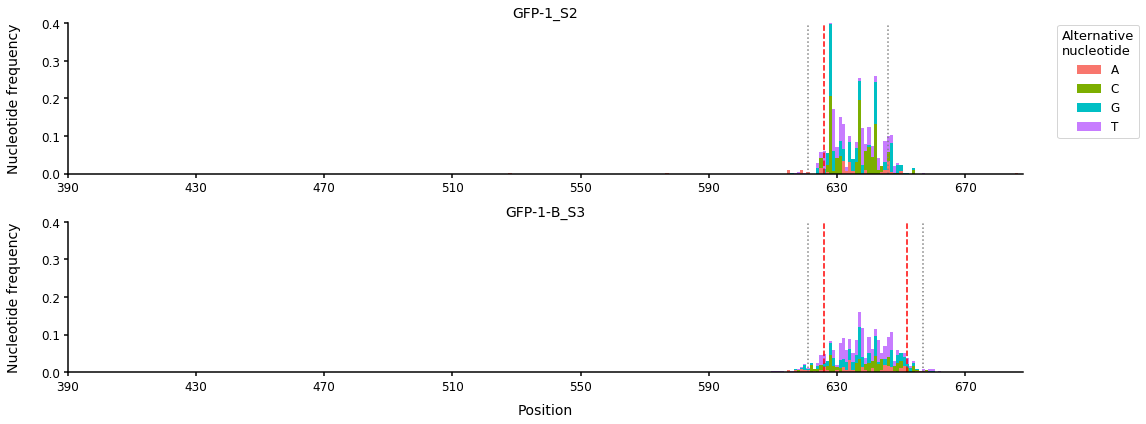

In [39]:
indel = 'Indel'

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(16, 6))

for n,f in enumerate(['GFP-1_S2', 'GFP-1-B_S3']):
    af_to_plot_by_indel[f][indel][['A', 'C', 'G', 'T']].plot(kind='bar', stacked=True, ax=ax[n],
        legend=False, width=1, color = ['#f8766d', '#7cae00', '#00bfc4','#c77cff'])
    ymax = {'GFP-1_S2':0.4, 'GFP-1-B_S3':0.4}
    ax[n].set_ylim(0, ymax[f])
    ax[n].set_xlim(ampl_coords[ampl_name][0]+19, ampl_coords[ampl_name][1]-20)
    ax[n].set_xticks([i for i in range(ampl_coords[ampl_name][0]+19, ampl_coords[ampl_name][1]-20, 40)])
    ax[n].set_xticklabels([i for i in range(ampl_coords[ampl_name][0]+19, ampl_coords[ampl_name][1]-20, 40)], size=12, rotation=0)
    for y in ax[n].get_yticklabels():
        y.set_size(12)
    ax[n].set_title(f, size=14)
    ax[n].spines['right'].set_visible(False)
    ax[n].spines['left'].set_linewidth(1.5)
    ax[n].spines['top'].set_visible(False)
    ax[n].spines['bottom'].set_linewidth(1.5)
    ax[n].tick_params(width=1.5, length=4)
    ax[n].set_ylabel('Nucleotide frequency', size=14, labelpad=20, color='k')
    guide_names = guides_by_sample[f]
    for guide_name in guide_names:
        nick = nick_sites[f][guide_name]
        ax[n].vlines(nick, 0, ymax[f], color='red', linestyle='--')
        if 'B' not in guide_names:
            ax[n].vlines(nick-upstream_window, 0, ymax[f], color='gray', linestyle='dotted')
            ax[n].vlines(nick+downstream_window, 0, ymax[f], color='gray', linestyle='dotted')
        else:
            if guide_name=='B':
                ax[n].vlines(nick+upstream_window, 0, ymax[f], color='gray', linestyle='dotted')
            else:
                ax[n].vlines(nick-upstream_window, 0, ymax[f], color='gray', linestyle='dotted')

lgd = ax[0].legend(loc='upper left', bbox_to_anchor=(1.03, 1.03),
                title ='Alternative\nnucleotide', prop={'size':12}, ncol=1)
plt.setp(lgd.get_title(),fontsize='13')
ax[-1].set_xlabel('Position', size=14, labelpad=10)
    
plt.tight_layout()
plt.show()